In [154]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime, timezone
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import time
import math
from implicit.als import AlternatingLeastSquares

In [11]:
ratings = pd.read_csv("./films_dataset/ratings_small.csv")
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


# Коллаборативная фильтрация

Изначальный файл ratings содержит 26024289 строк (это чересчур много для моего железа), я буду работать только ratings_small.

## EDA

In [16]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [18]:
# Посмотрим есть ли Nan в строках
sum(ratings.isna().sum(axis=1))

0

In [20]:
n_users = ratings['userId'].nunique()
n_items = ratings['movieId'].nunique()
n_ratings = len(ratings)
print(f"Пользователей: {n_users}, Фильмов: {n_items}, Оценок: {n_ratings}")

Пользователей: 671, Фильмов: 9066, Оценок: 100004


In [22]:
# Подсчет количества оценок для каждого пользователя и фильма
# Для коллаборативной фильтрации исключаем "холодных" пользователей и фильмы (с малым числом оценок),
# так как они добавляют шум и неинформативны для рекомендаций
user_counts = ratings.groupby('userId').size().rename('n_ratings_user')
item_counts = ratings.groupby('movieId').size().rename('n_ratings_item')

In [24]:
# Добавим эту информацию в исходный df
ratings = ratings.merge(user_counts, how='left', left_on='userId', right_index=True)
ratings = ratings.merge(item_counts, how='left', left_on='movieId', right_index=True)

Попробуем удалить малоинформативные фильмы и пользователей.

In [27]:
user_threshold = 5
item_threshold = 5

n_users_low = (user_counts < user_threshold).sum()
n_items_low = (item_counts < item_threshold).sum()
print(f"Пользователей с <{user_threshold} оценок: {n_users_low}")
print(f"Фильмов с <{item_threshold} оценок: {n_items_low}")

# сколько строк уйдёт при фильтрации
mask_users = ratings['n_ratings_user'] >= user_threshold
mask_items = ratings['n_ratings_item'] >= item_threshold
filtered_df = ratings[mask_users & mask_items].copy()
print(f"Размер после фильтрации (user>={user_threshold} & item>={item_threshold}): {filtered_df.shape}")

Пользователей с <5 оценок: 0
Фильмов с <5 оценок: 5570
Размер после фильтрации (user>=5 & item>=5): (90072, 6)


Как мы видим совсем холодных пользователей в df нет, но фильмы есть и их придется удалить.

In [30]:
filtered_df

,userId,movieId,rating,timestamp,n_ratings_user,n_ratings_item
0,1,31,2.5,1260759144,20,42
1,1,1029,3.0,1260759179,20,42
2,1,1061,3.0,1260759182,20,33
3,1,1129,2.0,1260759185,20,48
4,1,1172,4.0,1260759205,20,46
...,...,...,...,...,...,...
99998,671,6212,2.5,1065149436,115,7
100000,671,6269,4.0,1065149201,115,7
100001,671,6365,4.0,1070940363,115,82
100002,671,6385,2.5,1070979663,115,22


### Графики

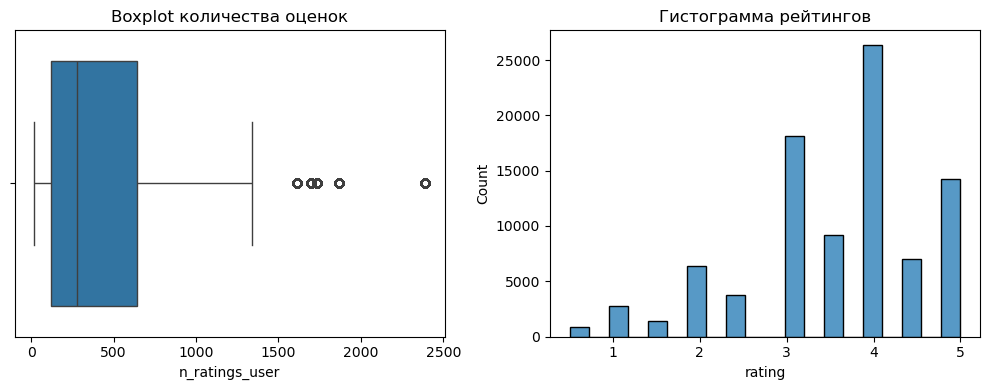

In [33]:
# Boxplot оценок 
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x=filtered_df['n_ratings_user'])
plt.title("Boxplot количества оценок")

# Гистограмма
plt.subplot(1,2,2)
sns.histplot(filtered_df['rating'], bins=20, kde=False)
plt.title("Гистограмма рейтингов")
plt.tight_layout()
plt.show()

In [34]:
top5_user_by_the_number_of_ratings = user_counts.sort_values().tail(5).index
top5_user_by_the_number_of_ratings

Index([73, 15, 624, 564, 547], dtype='int64', name='userId')

### Детекция ботов

In [38]:
# Сначала переведем дату из числового типа данных в временной
filtered_df['ts'] = pd.to_datetime(filtered_df['timestamp'], unit='s')
filtered_df

,userId,movieId,rating,timestamp,n_ratings_user,n_ratings_item,ts
0,1,31,2.5,1260759144,20,42,2009-12-14 02:52:24
1,1,1029,3.0,1260759179,20,42,2009-12-14 02:52:59
2,1,1061,3.0,1260759182,20,33,2009-12-14 02:53:02
3,1,1129,2.0,1260759185,20,48,2009-12-14 02:53:05
4,1,1172,4.0,1260759205,20,46,2009-12-14 02:53:25
...,...,...,...,...,...,...,...
99998,671,6212,2.5,1065149436,115,7,2003-10-03 02:50:36
100000,671,6269,4.0,1065149201,115,7,2003-10-03 02:46:41
100001,671,6365,4.0,1070940363,115,82,2003-12-09 03:26:03
100002,671,6385,2.5,1070979663,115,22,2003-12-09 14:21:03


In [40]:
# Поиск подозрительных пользователей (возможных ботов) по темпу выставления ими оценок

def compute_user_activity_stats(df):
    users = []
    for uid, group in df.groupby('userId'):
        times = group['ts'].sort_values().values
        count = len(times)
        first = times[0]
        last = times[-1]
        span_seconds = (last - first).astype('timedelta64[s]').astype(float)
        span_days = max(1.0, span_seconds / (3600 * 24))
        density_per_day = count / span_days
        times_seconds = times.astype('datetime64[s]').astype('int64')
        j = 0
        max_in_minute = 0
        for i in range(len(times_seconds)):
            while times_seconds[i] - times_seconds[j] > 60:  # 60 секунд
                j += 1
            max_in_minute = max(max_in_minute, i - j + 1)
        
        intervals = np.diff(times_seconds)
        std_intervals = np.std(intervals) if len(intervals) > 1 else float('inf')

        users.append((uid, count, span_days, density_per_day, max_in_minute, std_intervals))
    
    return pd.DataFrame(users, columns=['userId', 'count', 'span_days', 'density_per_day', 'max_in_minute', 'std_intervals'])
# статистики
user_activity = compute_user_activity_stats(filtered_df)
print(user_activity.describe().T)

                 count           mean           std        min         25%  \
userId           671.0     336.000000  1.938453e+02   1.000000  168.500000   
count            671.0     134.235469  1.868833e+02  16.000000   35.000000   
span_days        671.0     199.867520  6.688599e+02   1.000000    1.000000   
density_per_day  671.0      51.463885  8.520683e+01   0.019321    3.049017   
max_in_minute    671.0      11.406855  7.976451e+00   3.000000    8.000000   
std_intervals    671.0  629002.751385  1.860914e+06   0.818755   32.114340   

                        50%            75%           max  
userId           336.000000     503.500000  6.710000e+02  
count             66.000000     151.500000  1.449000e+03  
span_days          1.000000      37.680307  5.969788e+03  
density_per_day   29.000000      61.043174  1.048000e+03  
max_in_minute     10.000000      14.000000  1.290000e+02  
std_intervals    179.844879  222209.261806  2.233807e+07  


Мне пришлось провести собственный эксперимент и за минуту я поставил около 25 оценок, не смотря что это за фильм и не думая над оценкой. Будем использовать параметр 20 для оценки)

In [43]:
# Флаг подозрительных: более 20 оценок в минуту
sus_burst = 20
suspicious_users = user_activity[user_activity['max_in_minute'] > sus_burst]
print(f"Найдено подозрительных пользователей (max_in_minute > {sus_burst}): {len(suspicious_users)}")
print(suspicious_users)

Найдено подозрительных пользователей (max_in_minute > 20): 20
     userId  count    span_days  density_per_day  max_in_minute  std_intervals
14       15   1427  5455.943241         0.261550             22   2.301435e+06
22       23    652   212.293160         3.071225             21   6.351312e+05
41       42     70     1.000000        70.000000             22   4.482550e+00
55       56    428    99.121759         4.317922             29   1.179761e+05
81       82     39     1.000000        39.000000             22   6.315844e+00
90       91    131     1.000000       131.000000             24   1.252907e+03
94       95    251   106.938484         2.347144             32   4.409641e+05
212     213    746     1.000000       746.000000            129   1.239499e+02
223     224     84   276.738958         0.303535             51   1.293626e+06
269     270    200     1.000000       200.000000             84   2.256617e+03
310     311    827  2898.392326         0.285331             26   4.7

Пользователи 536 и 213 показали нереалистичные результаты. Придется их убрать

In [46]:
filtered_df = filtered_df[~filtered_df['userId'].isin([536, 213])]

In [48]:
# Флаг подозрительных: низкая вариация интервалов (< 1 сек) и достаточно оценок (>= 10)
sus_interval_std = 1
min_count = 10
suspicious_users = user_activity[(user_activity['std_intervals'] < sus_interval_std) & (user_activity['count'] >= min_count)]
print(f"Найдено подозрительных пользователей (interval_std < {sus_interval_std} и count >= {min_count}): {len(suspicious_users)}")
print(suspicious_users.head())

Найдено подозрительных пользователей (interval_std < 1 и count >= 10): 1
    userId  count  span_days  density_per_day  max_in_minute  std_intervals
34      35     20        1.0             20.0             20       0.818755


In [50]:
# Также подозрительный юзер 35 уберем
filtered_df = filtered_df[~filtered_df['userId'].isin([35])]

Рассмотрим тех самых пользователей с большим количеством оценок

In [53]:
df_year = filtered_df.copy()
df_year['year'] = filtered_df['ts'].dt.year

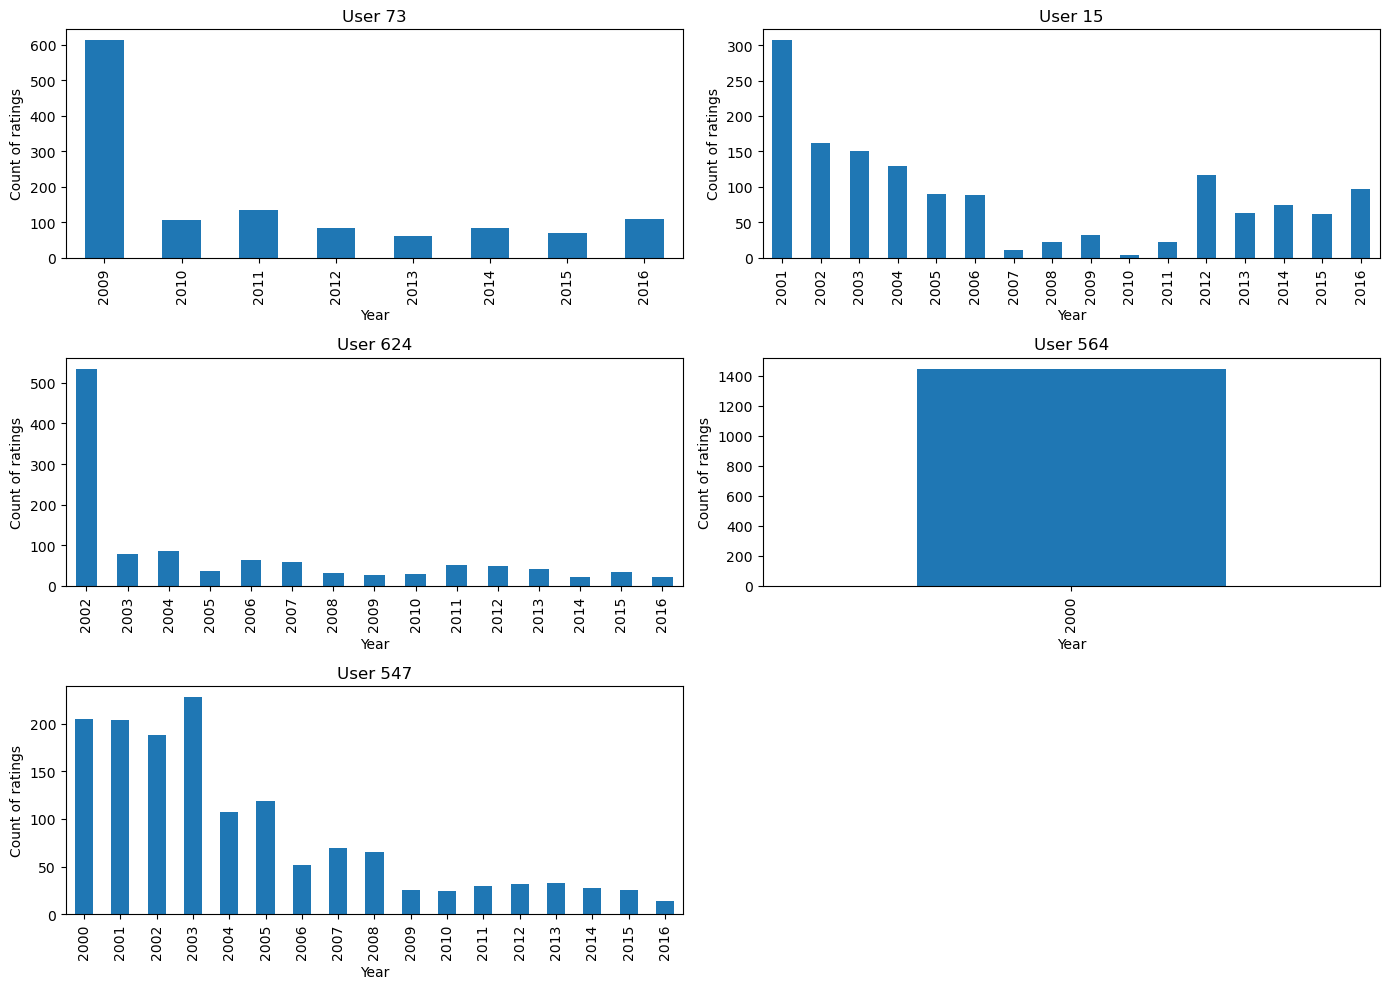

In [55]:
plt.figure(figsize=(14, 10))
for i, uid in enumerate(top5_user_by_the_number_of_ratings, 1):
    user_data = df_year[df_year['userId'] == uid]
    user_year_dist = user_data.groupby('year').size()
    plt.subplot(3, 2, i) 
    user_year_dist.plot(kind='bar')
    plt.title(f"User {uid}")
    plt.xlabel("Year")
    plt.ylabel("Count of ratings")

plt.tight_layout()
plt.show()

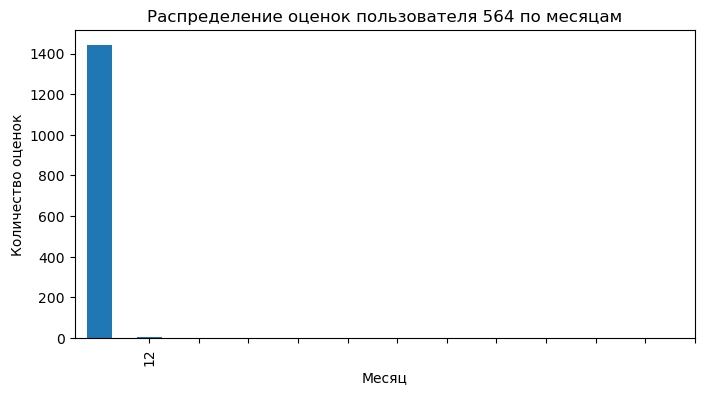

In [56]:
user_id = 564
user_data = df_year[df_year['userId'] == user_id].copy()
user_data['month'] = user_data['ts'].dt.month
user_month_dist = user_data.groupby('month').size()

plt.figure(figsize=(8, 4))
user_month_dist.plot(kind='bar')
plt.title("Распределение оценок пользователя 564 по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество оценок")
plt.xticks(range(1, 13))
plt.show()


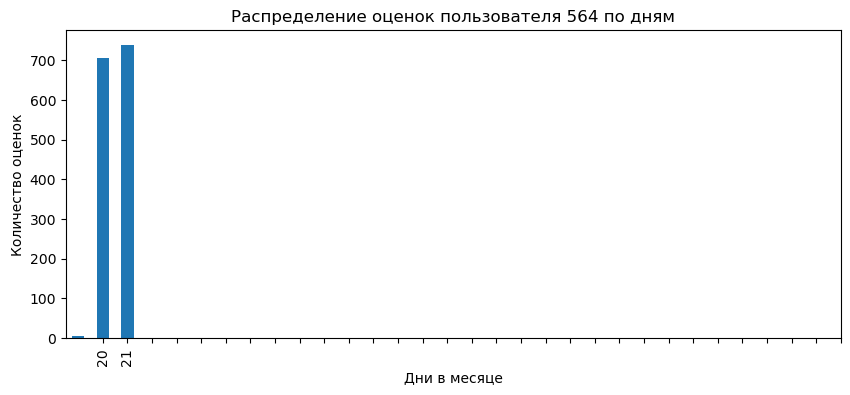

In [57]:
user_data['day'] = user_data['ts'].dt.day
user_day_dist = user_data.groupby('day').size()

plt.figure(figsize=(10, 4))
user_day_dist.plot(kind='bar')
plt.title("Распределение оценок пользователя 564 по дням")
plt.xlabel("Дни в месяце")
plt.ylabel("Количество оценок")
plt.xticks(range(1, 32))
plt.show()


Мне это кажется подозрительным, проверим распределение оценок.

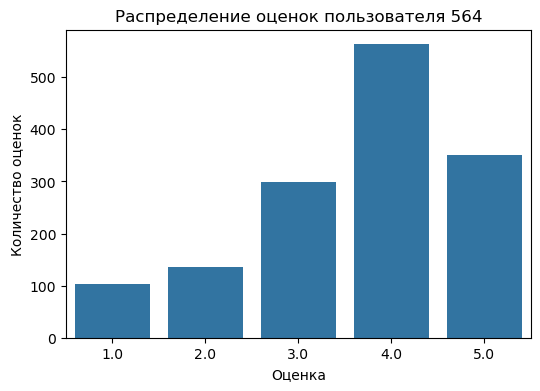

In [64]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=user_data)
plt.title("Распределение оценок пользователя 564")
plt.xlabel("Оценка")
plt.ylabel("Количество оценок")
plt.show()

Предположу, что это один из разработчиков сайта. Так как распределние абсолютно нормальное

## User2user rec

Начнем с небольшой нормализвации оценок 

In [70]:
ratings = filtered_df.copy()
user_mean = ratings.groupby('userId')['rating'].mean().rename('user_mean')
user_std = ratings.groupby('userId')['rating'].std().fillna(0).rename('user_std')

# добавляем в таблицу
ratings = ratings.merge(user_mean, left_on='userId', right_index=True)
ratings = ratings.merge(user_std, left_on='userId', right_index=True)

# центрированная оценка
ratings['rating_centered'] = ratings['rating'] - ratings['user_mean']

# нормализованная (Z-score)
ratings['rating_normalized'] = ratings['rating_centered'] / ratings['user_std'].replace(0, 1)
ratings

,userId,movieId,rating,timestamp,n_ratings_user,n_ratings_item,ts,user_mean,user_std,rating_centered,rating_normalized
0,1,31,2.5,1260759144,20,42,2009-12-14 02:52:24,2.550000,0.887041,-0.050000,-0.056367
1,1,1029,3.0,1260759179,20,42,2009-12-14 02:52:59,2.550000,0.887041,0.450000,0.507305
2,1,1061,3.0,1260759182,20,33,2009-12-14 02:53:02,2.550000,0.887041,0.450000,0.507305
3,1,1129,2.0,1260759185,20,48,2009-12-14 02:53:05,2.550000,0.887041,-0.550000,-0.620039
4,1,1172,4.0,1260759205,20,46,2009-12-14 02:53:25,2.550000,0.887041,1.450000,1.634648
...,...,...,...,...,...,...,...,...,...,...,...
99998,671,6212,2.5,1065149436,115,7,2003-10-03 02:50:36,3.929825,0.755151,-1.429825,-1.893429
100000,671,6269,4.0,1065149201,115,7,2003-10-03 02:46:41,3.929825,0.755151,0.070175,0.092929
100001,671,6365,4.0,1070940363,115,82,2003-12-09 03:26:03,3.929825,0.755151,0.070175,0.092929
100002,671,6385,2.5,1070979663,115,22,2003-12-09 14:21:03,3.929825,0.755151,-1.429825,-1.893429


In [72]:
ratings

,userId,movieId,rating,timestamp,n_ratings_user,n_ratings_item,ts,user_mean,user_std,rating_centered,rating_normalized
0,1,31,2.5,1260759144,20,42,2009-12-14 02:52:24,2.550000,0.887041,-0.050000,-0.056367
1,1,1029,3.0,1260759179,20,42,2009-12-14 02:52:59,2.550000,0.887041,0.450000,0.507305
2,1,1061,3.0,1260759182,20,33,2009-12-14 02:53:02,2.550000,0.887041,0.450000,0.507305
3,1,1129,2.0,1260759185,20,48,2009-12-14 02:53:05,2.550000,0.887041,-0.550000,-0.620039
4,1,1172,4.0,1260759205,20,46,2009-12-14 02:53:25,2.550000,0.887041,1.450000,1.634648
...,...,...,...,...,...,...,...,...,...,...,...
99998,671,6212,2.5,1065149436,115,7,2003-10-03 02:50:36,3.929825,0.755151,-1.429825,-1.893429
100000,671,6269,4.0,1065149201,115,7,2003-10-03 02:46:41,3.929825,0.755151,0.070175,0.092929
100001,671,6365,4.0,1070940363,115,82,2003-12-09 03:26:03,3.929825,0.755151,0.070175,0.092929
100002,671,6385,2.5,1070979663,115,22,2003-12-09 14:21:03,3.929825,0.755151,-1.429825,-1.893429


In [74]:
# Параметры
TEST_USER_FRAC = 0.2
N_NEIGHBORS = 15
TOP_K = 10
SEED = 42

In [84]:
# 1) выбрать тестовых пользователей
all_users = ratings['userId']
np.random.seed(SEED)
test_users = np.random.choice(all_users, size=int(len(all_users)*TEST_USER_FRAC), replace=False)
test_users = set(test_users)

In [86]:
# 2) для каждого забрать последние 5 оценок 
test_tails = ratings[ratings['userId'].isin(test_users)].groupby('userId').tail(5)
test_idx = test_tails.index
train_data = ratings.drop(test_idx).reset_index(drop=True)
test_data = ratings.loc[test_idx].reset_index(drop=True)

In [88]:
# 3) Строим URM матрицу
unique_users = train_data['userId'].unique()
unique_items = train_data['movieId'].unique()
user2row = {u:i for i,u in enumerate(unique_users)}
item2col = {it:i for i,it in enumerate(unique_items)}
rows = train_data['userId'].map(user2row).to_numpy()
cols = train_data['movieId'].map(item2col).to_numpy()
data = train_data['rating_normalized'].to_numpy()
URM = csr_matrix((data, (rows, cols)))

In [106]:
# 4) Ищем ближайших пользователей по косинусу
user_sim = cosine_similarity(URM, dense_output=True) 

def top_k_neighbors(sim_row, k):
    sim_copy = sim_row.copy()
    sim_copy[np.argmax(sim_row)] = -np.inf  # ensures self not selected if same index
    idx = np.argpartition(-sim_copy, range(min(k, len(sim_copy)-1)))[:k]
    idx = idx[np.argsort(-sim_copy[idx])]
    return idx

In [108]:
# 5) Рекомендуем
def recommend_for_user(uid, k_neighbors=N_NEIGHBORS, top_k=TOP_K):
    if uid not in user2row:
        return []  # Холод
    # Ищем К похожих пользователей
    urow = user2row[uid]
    neigh_idx = top_k_neighbors(user_sim[urow], k_neighbors)
    neigh_sims = user_sim[urow, neigh_idx]  # similarities
    # Смотрим их оценки
    neigh_matrix = URM[neigh_idx, :] 
    # Взвешенное суммирование
    weights = neigh_sims.reshape(-1,1)
    weighted = (neigh_matrix.multiply(weights)).toarray() 
    scores = weighted.sum(axis=0)  
    # Нормализация
    denom = (np.abs(weights).reshape(1, -1) @ (neigh_matrix != 0).toarray()).reshape(-1)
    sum_abs_sims = np.sum(np.abs(neigh_sims))
    if sum_abs_sims > 0:
        scores = scores / sum_abs_sims

    # Исключение уже просмотренных фильмов
    user_train_items = set(train_data[train_data['userId']==uid]['movieId'].unique())
    # Формирование рекомендаций
    candidate_indices = np.argsort(-scores)
    recommendations = []
    for idx in candidate_indices:
        # Не предлагаем плохой
        if scores[idx] <= 0:
            pass
        item_id = unique_items[idx]
        # Не предлагаем что уже видел
        if item_id in user_train_items:
            continue
        recommendations.append(item_id)
    return recommendations

In [156]:
# 6) Функции оценок моделей
def recall_at_k(recs, ground_truth_items, ground_truth_ratings, k):
    relevant_items = {item for item, rating in zip(ground_truth_items, ground_truth_ratings) 
                     if rating > 0}
    hit = sum(1 for r in recs[:k] if r in relevant_items)
    return hit / len(relevant_items)

def ndcg_at_k(recs, ground_truth_items, ground_truth_ratings, k):
    rating_dict = dict(zip(ground_truth_items, ground_truth_ratings))
        dcg = 0.0
    for i, item in enumerate(recs[:k]):
        rel = rating_dict.get(item, 0.0)
        dcg += rel / math.log2(i + 2)
    
    ideal_ratings = sorted([r for r in ground_truth_ratings if r > 0], reverse=True)
    ideal_ratings = ideal_ratings[:k]
    idcg = sum(rel / math.log2(i + 2) for i, rel in enumerate(ideal_ratings))
    return dcg / idcg if idcg > 0 else 0.0

In [194]:
# 7) Оцениваем модель
test_users_in_train = [u for u in test_users if u in user2row] 
recalls = []
ndcgs = []
times = []

for uid in test_users_in_train:
    user_test_df = test_data[test_data['userId'] == uid]
    gt_items = user_test_df['movieId'].tolist()
    gt_ratings = user_test_df['rating_normalized'].tolist()
    
    t0 = time.time()
    recs = recommend_for_user(uid)
    t1 = time.time()
    
    times.append(t1-t0)
    recalls.append(recall_at_k(recs, gt_items, gt_ratings, TOP_K))
    ndcgs.append(ndcg_at_k(recs, gt_items, gt_ratings, TOP_K))

print("Оценено пользователей:", len(test_users_in_train))
print(f"Recall@{TOP_K}: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"nDCG@{TOP_K}:   {np.mean(ndcgs):.4f} ± {np.std(ndcgs):.4f}")
print(f"Среднее время рекомендации на пользователя: {np.mean(times)*1000:.2f} мс (медиана {np.median(times)*1000:.2f} мс)")

Оценено пользователей: 668
Recall@10: 0.0454 ± 0.1527
nDCG@10:   0.0234 ± 0.1022
Среднее время рекомендации на пользователя: 2.59 мс (медиана 2.00 мс)


### Сравним c ALS

In [164]:
als_model = AlternatingLeastSquares(
    factors=64,
    regularization=0.01,
    iterations=15,
    random_state=SEED,
)
als_model.fit(URM)

In [192]:
test_users_in_train = [u for u in test_users if u in user2row]
als_recalls = []
als_ndcgs = []
als_times = []

for uid in test_users_in_train:
    user_test_df = test_data[test_data['userId'] == uid]
    gt_items = user_test_df['movieId'].tolist()
    gt_ratings = user_test_df['rating_normalized'].tolist()
    t0 = time.time()
    user_index = user2row[uid]
    user_row = URM[user_index]
    
    item_indices, scores = als_model.recommend(
        userid=user_index,
        user_items=user_row, 
        N=TOP_K,
        filter_already_liked_items=True
    )
    recs = [unique_items[idx] for idx in item_indices]
    
    t1 = time.time()
    
    als_times.append(t1 - t0)
    als_recalls.append(recall_at_k(recs, gt_items, gt_ratings, TOP_K))
    als_ndcgs.append(ndcg_at_k(recs, gt_items, gt_ratings, TOP_K))

print("РЕЗУЛЬТАТЫ ОЦЕНКИ ALS МОДЕЛИ")
print(f"Recall@{TOP_K}:{np.mean(als_recalls):.2f} ± {np.std(als_recalls):.2f}")
print(f"nDCG@{TOP_K}:{np.mean(als_ndcgs):.2f} ± {np.std(als_ndcgs):.2f}")
print(f"Среднее время рекомендации на пользователя: {np.mean(als_times):.5f}")

РЕЗУЛЬТАТЫ ОЦЕНКИ ALS МОДЕЛИ
Recall@10:0.07 ± 0.19
nDCG@10:0.03 ± 0.16
Среднее время рекомендации на пользователя: 0.00018
